In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint 
from lmfit import minimize, Parameters, Parameter, report_fit #download lmfit: https://lmfit.github.io/lmfit-py/installation.html
from scipy.signal import savgol_filter

In [2]:
df_10k = pd.read_csv ('10krace.csv')
df_sub_19_5k = pd.read_csv ('sub_19_5k.csv')
df_sub_20_5k = pd.read_csv ('sub_20_5k.csv')
df_sub_21_5k = pd.read_csv ('sub_21_5k.csv')


secs_sub_19 = np.array(df_sub_19_5k['secs'].tolist())
secs_sub_20 = np.array(df_sub_20_5k['secs'].tolist())
secs_sub_21 = np.array(df_sub_21_5k['secs'].tolist())

hr_sub_19 = df_sub_19_5k['hr'].tolist()
hr_sub_20 = df_sub_20_5k['hr'].tolist()
hr_sub_21 = df_sub_21_5k['hr'].tolist()

speed_kph_sub_19 = df_sub_19_5k['kph'].tolist()
speed_kph_sub_20 = df_sub_20_5k['kph'].tolist()
speed_kph_sub_21 = df_sub_21_5k['kph'].tolist()

df_sub_19_5k.head()

,secs,cad,hr,km,kph,nm,watts,alt,lon,lat,...,interval,lrbalance,lte,rte,lps,rps,smo2,thb,o2hb,hhb
0,1,0,107,0.001118,4.02581,0,0,-3.20,54.437095,24.531051,...,0,-255,0,0,0,0,0,0,0,0
1,2,0,108,0.003040,6.91921,0,0,-1.80,54.437114,24.531051,...,0,-255,0,0,0,0,0,0,0,0
2,3,83,108,0.006894,8.31038,0,0,-1.88,54.437152,24.531057,...,0,-255,0,0,0,0,0,0,0,0
3,4,83,108,0.010749,9.70154,0,0,-1.96,54.437189,24.531062,...,0,-255,0,0,0,0,0,0,0,0
4,5,83,108,0.014603,11.09270,0,0,-2.04,54.437227,24.531068,...,0,-255,0,0,0,0,0,0,0,0


Simply plotting my heart rate and speed data:

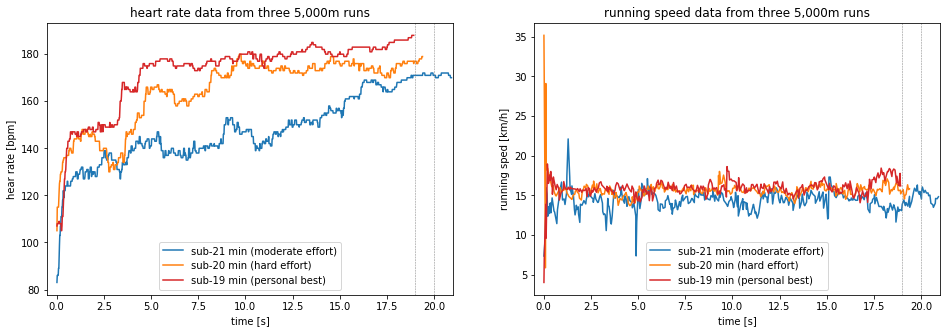

In [19]:
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(16, 5))

plt1.plot(secs_sub_21/60,hr_sub_21,color="tab:blue",label='sub-21 min (moderate effort)')
plt1.plot(secs_sub_20/60,hr_sub_20,color="tab:orange",label='sub-20 min (hard effort)')
plt1.plot(secs_sub_19/60,hr_sub_19,color="tab:red",label='sub-19 min (personal best)')
plt1.set_xlabel('time [s]')
plt1.set_ylabel('hear rate [bpm]')
plt1.set_title("heart rate data from three 5,000m runs")
plt1.axvline(x=20,color="grey",linestyle='--',linewidth=0.5)
plt1.axvline(x=19,color="grey",linestyle='--',linewidth=0.5)
plt1.set_xlim([-0.5,21])
plt1.legend()

plt2.plot(secs_sub_21/60,speed_kph_sub_21,color="tab:blue",label='sub-21 min (moderate effort)')
plt2.plot(secs_sub_20/60,speed_kph_sub_20,color="tab:orange",label='sub-20 min (hard effort)')
plt2.plot(secs_sub_19/60,speed_kph_sub_19,color="tab:red",label='sub-19 min (personal best)')
plt2.set_xlabel("time [s]")
plt2.set_ylabel("running sped [km/h]")
plt2.set_title("running speed data from three 5,000m runs")
plt2.axvline(x=20,color="grey",linestyle='--',linewidth=0.5)
plt2.axvline(x=19,color="grey",linestyle='--',linewidth=0.5)
plt2.set_xlim([-0.5,21])
plt2.legend()

plt.savefig('heart-rate_speed_data.png', dpi=300)

The following cell defines the used ODE model:
$$
\begin{split}
    \dot{x}_1 &= -a_1 x_1(t) + a_2 x_2(t) + a_2 u^2(t) \\
    \dot{x}_2 &= -a_3 x_2(t)+\frac{a_4 x_1(t)}{1+e^{-(x1(t)-a_5)}}
\end{split}
$$

In [4]:
def ode_model(X,t,a1,a2,a3,a4,a5):
    norm_speed = 1
    x1,x2 = X
    x1_dot = -a1*x1 + a2*(x2+norm_speed**2)
    phi = a4*x1/(1+np.exp(-(x1-a5)))
    x2_dot = -a3*x2 + phi
    return [x1_dot,x2_dot]

The following cell defines two functions, both of them used for fitting the data into the five parameters. One is used for integrating the system of ODEs, while the other defines the error (deviation of real data from a fit that uses the sought parameters) which is to be minimized.

In [5]:
def ode_solver(t, initial_conditions, params):
    x1_init, x2_init = initial_conditions
    a1, a2, a3, a4, a5 = params['a1'].value, params['a2'].value, params['a3'].value, params['a4'].value, params['a5'].value
    res = odeint(ode_model, [0,0], t, args=(a1,a2,a3,a4,a5))
    return res

def error(params, initial_conditions, tspan, data):
    sol = ode_solver(tspan, initial_conditions, params)
    return (sol[:,0] - data).ravel() #I'm only interested in minimizing x1 (there are no x2-feedback data recorded)

In [6]:
#initial conditions
x1_init = 0
x2_init = 0
initial_conditions = [x1_init, x2_init]

HR_rest_sub_19 = hr_sub_19[0] #reasting heart rate, essentially the heart rate recorded at race start
HR_rest_sub_20 = hr_sub_20[0]
HR_rest_sub_21 = hr_sub_21[0]

#initial parameter guess (estimate based on https://ieeexplore.ieee.org/document/4539791)
a1 = 2
a2 = 20
a3 = 4e-2
a4 = 2e-3
a5 = 8

params = Parameters()
params.add('a1', value=a1, min=0, max=20)
params.add('a2', value=a2, min=0, max=40)
params.add('a3', value=a3, min=0, max=5)
params.add('a4', value=a4, min=0, max=5)
params.add('a5', value=a5, min=0, max=40)

sub_21_data = np.array(hr_sub_21)-HR_rest_sub_21
sub_21_result = minimize(error, params, args=(initial_conditions, secs_sub_21, sub_21_data), method='leastsq')
sub_21_final_x1 = sub_21_data + sub_21_result.residual.reshape(sub_21_data.shape)

sub_20_data = np.array(hr_sub_20)-HR_rest_sub_20
sub_20_result = minimize(error, params, args=(initial_conditions, secs_sub_20, sub_20_data), method='leastsq')
sub_20_final_x1 = sub_20_data + sub_20_result.residual.reshape(sub_20_data.shape)

sub_19_data = np.array(hr_sub_19)-HR_rest_sub_19
sub_19_result = minimize(error, params, args=(initial_conditions, secs_sub_19, sub_19_data), method='leastsq')
sub_19_final_x1 = sub_19_data + sub_19_result.residual.reshape(sub_19_data.shape)


In [7]:
def extract_params(result):
    a1 = result.params.valuesdict()["a1"]
    a2 = result.params.valuesdict()["a2"]
    a3 = result.params.valuesdict()["a3"]
    a4 = result.params.valuesdict()["a4"]
    a5 = result.params.valuesdict()["a5"]
    params = (a1, a2, a3, a4, a5) #return a tuple (for an easy pass into odeint())
    return params

In [8]:
sub_21_params = extract_params(sub_21_result)
sub_20_params = extract_params(sub_20_result)
sub_19_params = extract_params(sub_19_result)

In [9]:
t = np.linspace(0,1200,1200)
sub_21_fit = odeint(ode_model, [0,0], secs_sub_21, args=sub_21_params)
sub_20_fit = odeint(ode_model, [0,0], secs_sub_20, args=sub_20_params)
sub_19_fit = odeint(ode_model, [0,0], secs_sub_19, args=sub_19_params)

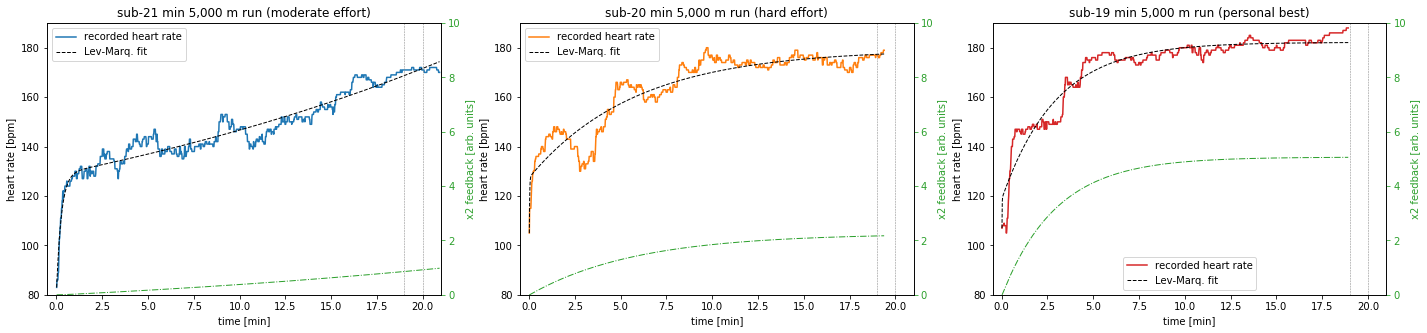

In [18]:
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(24, 5))

plt1.plot(secs_sub_21/60, hr_sub_21, color="tab:blue",label='recorded heart rate')
plt1.plot(secs_sub_21/60, np.array(sub_21_final_x1)+HR_rest_sub_21, '--', linewidth=1, color='black',label="Lev-Marq. fit")
plt1.set_xlim([-0.5,21])
plt1.set_ylim([80,190])
plt1.set_xlabel("time [min]")
plt1.set_ylabel("heart rate [bpm]")
plt1.set_title("sub-21 min 5,000 m run (moderate effort)")
plt1.axvline(x=20,color="grey",linestyle='--',linewidth=0.5)
plt1.axvline(x=19,color="grey",linestyle='--',linewidth=0.5)
plt1.legend()

ax1 = plt1.twinx()
ax1.plot(secs_sub_21/60,sub_21_fit[:,1],color="tab:green",linestyle="-.",label="x2 feedback",linewidth=1)
ax1.set_ylabel("bodily feedback [arb. units]",color="tab:green")
ax1.tick_params(axis='y', colors='tab:green')
ax1.set_ylim([0,10])


plt2.plot(secs_sub_20/60, hr_sub_20, color="tab:orange",label='recorded heart rate')
plt2.plot(secs_sub_20/60, np.array(sub_20_final_x1)+HR_rest_sub_20, '--', linewidth=1, color='black',label="Lev-Marq. fit")
plt2.set_xlim([-0.5,21])
plt2.set_ylim([80,190])
plt2.set_xlabel("time [min]")
plt2.set_ylabel("heart rate [bpm]")
plt2.set_title("sub-20 min 5,000 m run (hard effort)")
plt2.axvline(x=20,color="grey",linestyle='--',linewidth=0.5)
plt2.axvline(x=19,color="grey",linestyle='--',linewidth=0.5)
plt2.legend()

ax2 = plt2.twinx()
ax2.plot(secs_sub_20/60,sub_20_fit[:,1],color="tab:green",linestyle="-.",label="x2 feedback",linewidth=1)
ax2.set_ylabel("bodily feedback [arb. units]",color="tab:green")
ax2.tick_params(axis='y', colors='tab:green')
ax2.set_ylim([0,10])

plt3.plot(secs_sub_19/60, hr_sub_19, color="tab:red",label='recorded heart rate')
plt3.plot(secs_sub_19/60, np.array(sub_19_final_x1)+HR_rest_sub_19, '--', linewidth=1, color='black',label="Lev-Marq. fit")
plt3.set_xlim([-0.5,21])
plt3.set_ylim([80,190])
plt3.set_xlabel("time [min]")
plt3.set_ylabel("heart rate [bpm]")
plt3.set_title("sub-19 min 5,000 m run (personal best)")
plt3.axvline(x=20,color="grey",linestyle='--',linewidth=0.5)
plt3.axvline(x=19,color="grey",linestyle='--',linewidth=0.5)
plt3.legend(loc="lower center")

ax3 = plt3.twinx()
ax3.plot(secs_sub_19/60,sub_19_fit[:,1],color="tab:green",linestyle="-.",label="x2 feedback",linewidth=1)
ax3.set_ylabel("bodily feedback [arb. units]",color="tab:green")
ax3.tick_params(axis='y', colors='tab:green')
ax3.set_ylim([0,10])

plt.savefig('heart_rate_fits.png', dpi=300)